# Оценка стратегии методом Монте-Карло

Рассмотрим работу методов Монте-Карло в задачах обучения с подкреплением на практике. Сначала реализуем метод оценки стратегии с помощью метода Монте-Карло. 

В методах Монте-Карло агент обучается через взаимодействие со средой. Поэтому имеет смысл реализовать агента как класс в Python, который внутри себя хранит оценки V- или Q-функций, а также будет иметь несколько методов:

    `reset()` для сброса оценок,
    `update()` для обновления оценок,
    `get_action()` для выбора действия.
    
Такого агента будет называть "табличным агентом", поскольку V- или Q-функция для конечного числа состояний представляет собой массив (или таблицу) значений.

Программно V- или Q-функцию удобно реализовать с помощью специального класса `defaultdict`, экземпляры которого представляют собой так называемый словарь со значениями по умолчанию. Это означает, что с экземплярами этого класса можно обращаться как с обычным словарём, но при обращении к такому словарю по ключу, которого там нет, словарь выдаёт не ошибку (как обычный словарь в Python), а создаёт для этого ключа значение по умолчанию. Значение по умолчанию задаётся с помощью ламбда-функции (или безымянной функции) при создании экземпляра класса `defaultdict`. Использование такого словаря моделирует ситуацию, когда агент заранее ничего не значет о среде и заполняет словарь по ходу взаимодействия. 

Для начала реализуем агента, которые будет формировать оценку V-функции некоторой стратегии. Эту стратегию агенту можно будет передать при инициализации экземпляра класса. Отметим также следующие моменты.

    Метод `get_action()` будет выдавать действия в соответствии с указанной стратегий. Программно стратегию также будем реализовывать с помощью словаря `defaultdict`, ключами будут состояния, а значениями будут вектора вероятности выбора действий.  Стратегией по умолчанию будет стратегия равновероятного выбора действий.

    Метод `update()` будет иметь два аргумента: `state` и `goal` и будет обновлять оценку для значения `V[state]` в сторону целевого значения `goal`.

In [5]:
import numpy as np
from collections import defaultdict

class VTableAgent:
    # инициализация
    def __init__(self, env, policy = None, alpha = None):
        self.nA = env.action_space.n # число действий
        self.V = defaultdict(lambda: 0)   # словарь для оценок ценностей состояний, значение по умолчанию равно 0
        self.N = defaultdict(lambda: 0)   # словарь для счётчиков числа посещений состояний       
        self.alpha = alpha           # параметр шага обучения
        if policy is None:
            self.policy = defaultdict(lambda: np.ones(self.nA)/self.nA)
        else:
            self.policy = policy
            
    def reset(self):
        self.N = defaultdict(lambda: 0)
        self.V = defaultdict(lambda: 0)   
        
    def get_action(self, state):
        # выбор действия в соответствии со стратегией
        return np.random.choice(self.nA, p=self.policy[state]) 
    
    def update(self, state, goal):
        # обновление оценки по методу выборочного среднего или с постоянным шагом обновления
        if self.alpha is None:
            self.N[state] += 1
            self.V[state] += (goal - self.V[state])/self.N[state]
        else:
            self.V[state] += alpha*(goal - self.V[state])                       

Кроме того, потребуется метод `generate_episode()`, который будет генерировать эпизод в котором агент действует по своей стратегии. Результатом будет траектория взаимодействия агента со средой $S_0,A_0,R_1,S_1,A_1,...,S_{T-1},A_{T-1},R_{T},S_{T}$, где $T$ - это временной шаг перехода в заключительное состояние. Программно траекторией будет список в Python из кортежей вида `(state, action, reward)` $ = (S_{k},A_{k},R_{k+1})$, $k=0,...,T-1$.

Метод для оценки стратегии `MC_V_Evaluation()` принимает на вход аргументы:

    env: среда
    agent: агент
    num_episodes: число эпизодов для обучения

Также дополнительно можно передавать коэффициент обесценивания `gamma` и флаг `first_visit`, позволяющий вычислять оценку ценности по методу МК первого или всех посещений.

In [7]:
from tqdm import tqdm

def generate_episode(env, agent):    
    episode = [] #список для хранения траектории
    state, _ = env.reset()    
    while True:   
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)      
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
                break
    return episode

def MC_V_Evaluation(env, agent, num_episodes, gamma=1.0, first_visit=False):  
    # Цикл по числу эпизодов
    for i_episode in tqdm(range(num_episodes)):
        # генерация эпизода
        episode = generate_episode(env, agent)
        # если МК первого посещения, то выделим из эпизода все состояния
        if first_visit:
            episode_states, _, _ = zip(*episode)

        # подсчёт доходов и обновление оценок
        G = 0
        ep_length = len(episode)
        # реализуем алгоритм из лекций
        for t in range(ep_length-1, -1, -1):
            s, a, r = episode[t]
            G = gamma * G + r
            if first_visit:
                if s not in episode_states[:t]:
                    agent.update(s,G)
            else:
                agent.update(s,G)

### Пример 1

Применим метод МК для оценки стратегии в задаче о клеточном мире размера 4 на 4 клетки.
Подгрузим среду и создадим агента.

In [9]:
from custom.env.gridworld import GridWorld4by4

gamma = 1.0
env = GridWorld4by4()
agent = VTableAgent(env)

Сгенерируем для примера несколько эпизодов.

In [11]:
# проверка работы генерации эпизодов
for i in range(3):
    print('Episode ', i+1, ":")
    print(generate_episode(env, agent))

Episode  1 :
[(4, 1, -1), (8, 0, -1), (8, 1, -1), (12, 0, -1), (12, 1, -1), (12, 2, -1), (13, 1, -1), (13, 3, -1), (9, 1, -1), (13, 1, -1), (13, 1, -1), (13, 1, -1), (13, 2, -1), (14, 1, -1), (14, 3, -1), (10, 0, -1), (9, 0, -1), (8, 3, -1), (4, 3, -1), (0, 2, 0)]
Episode  2 :
[(10, 1, -1), (14, 0, -1), (13, 1, -1), (13, 0, -1), (12, 0, -1), (12, 1, -1), (12, 1, -1), (12, 1, -1), (12, 0, -1), (12, 1, -1), (12, 1, -1), (12, 0, -1), (12, 3, -1), (8, 1, -1), (12, 0, -1), (12, 2, -1), (13, 0, -1), (12, 0, -1), (12, 1, -1), (12, 3, -1), (8, 0, -1), (8, 0, -1), (8, 2, -1), (9, 0, -1), (8, 0, -1), (8, 2, -1), (9, 1, -1), (13, 2, -1), (14, 3, -1), (10, 0, -1), (9, 2, -1), (10, 2, -1), (11, 1, -1), (15, 2, 0)]
Episode  3 :
[(9, 3, -1), (5, 3, -1), (1, 2, -1), (2, 1, -1), (6, 2, -1), (7, 2, -1), (7, 0, -1), (6, 0, -1), (5, 0, -1), (4, 3, -1), (0, 1, 0)]


Применим метод оценки стратегии, по умолчанию агент действует по стратегии с равновероятным выбором действий.

In [13]:
MC_V_Evaluation(env, agent, 10000, first_visit = True)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1441.59it/s]


In [15]:
agent.V

defaultdict(<function __main__.VTableAgent.__init__.<locals>.<lambda>()>,
            {0: 0.0,
             1: -14.199589883800414,
             2: -20.00866510538645,
             6: -19.9964055996973,
             13: -20.41987102937674,
             14: -14.098855835240306,
             10: -18.1772853185596,
             7: -19.904683840749435,
             11: -14.055830706888782,
             5: -18.11813036333758,
             3: -22.10346872220575,
             15: 0.0,
             9: -20.25925925925927,
             4: -13.827371695178869,
             12: -22.681155105686173,
             8: -20.13772032902467})

Эти значения для равновероятной стратегии близки к точным значениям, посчитанным при использовании методов ДП.
Выведем полученные значения ценностей в более удобном виде.

In [17]:
V_list = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        pos = 4*i+j
        V_list[i,j] = agent.V[pos]
    
V_list

array([[  0.        , -14.19958988, -20.00866511, -22.10346872],
       [-13.8273717 , -18.11813036, -19.9964056 , -19.90468384],
       [-20.13772033, -20.25925926, -18.17728532, -14.05583071],
       [-22.68115511, -20.41987103, -14.09885584,   0.        ]])

Можно также найти ценности состояний для оптимальной стратегии. Для этого создадим агента, подгрузив в него оптимальную стратегию, найденную методами ДП. Для этого скопируем оптимальную стратегию из предыдущего файла и сформируем словарь со стратегией.

In [21]:
opt_policy_array=[[0.25, 0.25, 0.25, 0.25],
 [1.,   0.,   0.,   0.  ],
 [1.,   0.,   0.,   0.  ],
 [0.5,  0.5,  0.,   0.  ],
 [0.,   0.,   0.,   1.  ],
 [0.5,  0.,   0.,   0.5 ],
 [0.25, 0.25, 0.25, 0.25],
 [0.,   1.,   0.,   0.  ],
 [0.,   0.,   0.,   1.  ],
 [0.25, 0.25, 0.25, 0.25],
 [0.,   0.5,  0.5,  0.  ],
 [0.,   1.,   0.,   0.  ],
 [0.,   0.,   0.5,  0.5 ],
 [0.,   0.,   1.,   0.  ],
 [0.,   0.,   1.,   0.  ],
 [0.25, 0.25, 0.25, 0.25]]

keys = list(range(16))
values = opt_policy_array

opt_policy_dict = dict(zip(keys, values))
print(opt_policy_dict)

{0: [0.25, 0.25, 0.25, 0.25], 1: [1.0, 0.0, 0.0, 0.0], 2: [1.0, 0.0, 0.0, 0.0], 3: [0.5, 0.5, 0.0, 0.0], 4: [0.0, 0.0, 0.0, 1.0], 5: [0.5, 0.0, 0.0, 0.5], 6: [0.25, 0.25, 0.25, 0.25], 7: [0.0, 1.0, 0.0, 0.0], 8: [0.0, 0.0, 0.0, 1.0], 9: [0.25, 0.25, 0.25, 0.25], 10: [0.0, 0.5, 0.5, 0.0], 11: [0.0, 1.0, 0.0, 0.0], 12: [0.0, 0.0, 0.5, 0.5], 13: [0.0, 0.0, 1.0, 0.0], 14: [0.0, 0.0, 1.0, 0.0], 15: [0.25, 0.25, 0.25, 0.25]}


Создадим агента, передадим в него стратегию.

In [31]:
gamma = 1.0
env = GridWorld4by4()
agent = VTableAgent(env, policy = opt_policy_dict)

episode = generate_episode(env,agent)
episode

[(8, 3, -1), (4, 3, -1), (0, 3, 0)]

In [35]:
MC_V_Evaluation(env, agent, 50, first_visit = True)

V_list = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        pos = 4*i+j
        V_list[i,j] = agent.V[pos]
    
V_list

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6266.89it/s]


array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

Действительно, найденные значения ценности состояний соответствуют точным.

### Пример 2

Далее, рассмотрим среду **Blackjack** пакета `gymnasium`. Она отличается от сред, рассмотренных выше тем, что у ней нет поля `env.P`, то есть нет явно заданной модели среды. 

Эпизод заключается в следующем: 2 карты сдаются агенту и дилеру. Агент видит свои карты и одну карту дилера. Картам присвоена стоимость в очках: 
1. числовые карты от 2 до 10 дают столько очков, сколько написано на карте, 
2. буквенные карты дают 10 очков,
3. туз даёт 1 или 11 очков (а именно, туз даёт 11 очков пока общая сумма не больше 21, если сумма превысила 21, то туз даёт 1 очко).

Цель набрать число очков как можно ближе к 21 снизу. 

1. Если сумма очков больше 21, то агент проигрывает. 
2. Если сумма очков меньше 21, но больше чем у дилера, то агент выигрывает. 
3. Если сумма очков меньше 21, но меньше чем у дилера, то агент проигрывает. 
4. Если равное число очков и меньше 21, то ничья.

Вознаграждения:

    - выигрыш: +1
    - проигрыш: -1
    - ничья: 0
    
Есть также опция при создании среды указать параметр `natural`. По умолчанию этот параметр равен `False`. Этот параметр позволяет начислять дополнительное вознаграждение за стартовую комбинацию 10 + туз у игрока.
    
    - победа с комбинацией 10+туз:
        +1.5 (если natural = True)
        +1 (если natural = False)


Сначала подгрузим и изучим среду.

In [37]:
import gymnasium as gym

env = gym.make('Blackjack-v1')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Состояние среды представлет собой массив из трёх значений:
    
    (текущая сумма очков агента, открытая карта дилера, флаг о возможности использовать туз)
    
Флаг будет имет значение `True`, если есть туз, дающий 11 очков (и его можно при дальнейшем наборе карт считать за одно очко при переполнении).

Флаг будет имет значение `False`, если есть туза нет или он уже использован, то есть даёт 1 очко.

У агента в каждом состоянии есть два действия:

    Не брать = 0
    Брать = 1

Для демонстрации запустим симуляцию эпизода игры, где агент случайным образом выбирает действие.

In [39]:
for i_episode in range(2):  
    state, _ = env.reset()
    print('Состояние:', state)
    while True:       
        
        # выбрать случайное действие
        action = env.action_space.sample()
        if action == 0:
            print("Действие: Пас")
        else:
            print("Действие: Беру")
        
        state, reward, terminated, _, _ = env.step(action)
        print('Состояние:', state)
        if terminated:           
            print('Конец игры! Вознаргаждение: ', reward)
            print('Победа :)\n') if reward > 0 else print('Проигрыш :(\n')
            break

Состояние: (15, 2, 0)
Действие: Беру
Состояние: (21, 2, 0)
Действие: Беру
Состояние: (25, 2, 0)
Конец игры! Вознаргаждение:  -1.0
Проигрыш :(

Состояние: (20, 7, 0)
Действие: Пас
Состояние: (20, 7, 0)
Конец игры! Вознаргаждение:  1.0
Победа :)



#### Оценка стратегии в среде Blackjack

Оценим функцию ценности состояний, например, для следующей стратегии: 
1. агент пасует с веротяностью 80%, если сумма его карт больше 18
2. агент берёт с веротяностью 80%, если сумма его карт меньше или равна 18. 

In [45]:
gamma = 1.0
env = gym.make('Blackjack-v1')
# создаём стратегию
policy = {}
for i1 in range(env.observation_space[0].n):
    for i2 in range(env.observation_space[1].n):
        for i3 in range(env.observation_space[2].n):
            if i1 > 18:
                policy[(i1,i2,i3)] = [0.8, 0.2]
            else:
                policy[(i1,i2,i3)] = [0.2, 0.8]

# создаём агента
agent = VTableAgent(env, policy = policy)

# проверка работы генерации эпизодов
for i in range(5):
    print('Episode ', i+1, ':')
    print(generate_episode(env, agent))

Episode  1 :
[((13, 10, 0), 1, 0.0), ((15, 10, 0), 1, 0.0), ((21, 10, 0), 0, 1.0)]
Episode  2 :
[((6, 6, 0), 1, 0.0), ((14, 6, 0), 1, 0.0), ((19, 6, 0), 0, -1.0)]
Episode  3 :
[((20, 3, 0), 0, 1.0)]
Episode  4 :
[((8, 7, 0), 1, 0.0), ((18, 7, 0), 0, 0.0)]
Episode  5 :
[((13, 3, 0), 1, -1.0)]


In [49]:
# проверка работы выбора действия по заданной стратегии
all_actions = [agent.get_action((17, 7, False)) for i in range(10000)]
np.sum(all_actions)

7984

Запустим процесс оценивания для 100000 эпизодов.

In [19]:
MC_V_Evaluation(env, agent, 50000)
V=agent.V

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:09<00:00, 5452.07it/s]


Для визуализации получившихся результатов надо преобразовать словарь V в массивы со значениями по оси Ox, по оси Oy и значений ценностей.

    По оси Ox будем откладывать сумму очков игрока от 11 до 21 
    По оси Oy будем откладывать число очков на открытой карте дилера от 1 до 10
    По оси Oz будем откладывать значение функции ценности для каждой пары (x,y)
    
Кроме того, надо будет построить два отдельных графика: один - при возможности использовать туз, второй - без туза или когда он уже использован.

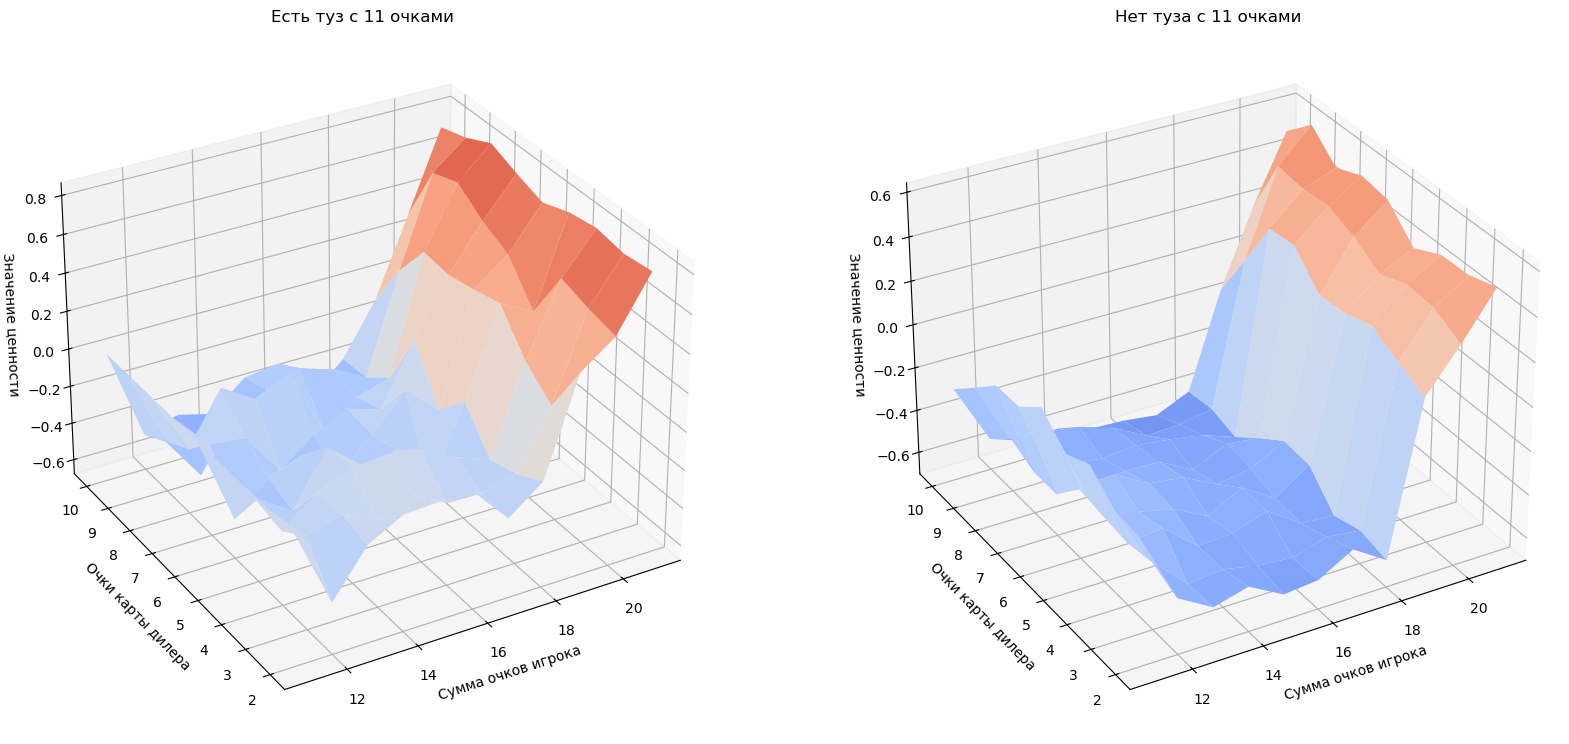

In [21]:
import matplotlib.pyplot as plt
# функция для построения графика
def get_figure(V, usable_ace, ax):
    # создание списка аргументов
    x_range = np.arange(11, 22)
    y_range = np.arange(2, 11)
    X, Y = np.meshgrid(x_range, y_range)
    all_x_y = zip(np.ravel(X), np.ravel(Y))
    # получаем значения по оси Oz 
    Z = np.array([V[x, y, usable_ace] for x,y in all_x_y])
    Z = Z.reshape(X.shape)
    # строим 3D график
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Сумма очков игрока')
    ax.set_ylabel('Очки карты дилера')
    ax.set_zlabel('Значение ценности')
    #установка угла зрения на график
    ax.view_init(30, -120)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Есть туз с 11 очками')
get_figure(V, True, ax)
ax = fig.add_subplot(122, projection='3d')
ax.set_title('Нет туза с 11 очками')
get_figure(V, False, ax)

Выбранная стратегия, говорящая не брать карту в 80% случаев при числе очков больше 18, даёт выоские значения ценности. Однако, взятие карты в 80% случаев при числе очков меньше 18 даёт низкие значения ценности состояний.

Подсчитаем средний выигрыш при такой стратегии на большом числе эпизодов.

In [51]:
def play(env, agent, n_episodes):
    for episode in range(n_episodes):
        nA = env.action_space.n 
        state, _ = env.reset()
        while True:
            # выбираем действия по стратегии
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

In [53]:
n_episodes = 10000
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

play(env, agent, n_episodes)

In [54]:
print('Процент победных эпизодов: ', np.round(env.return_queue.count(1.0)/n_episodes*100,2))
print('Процент проигранных эпизодов: ', np.round(env.return_queue.count(-1.0)/n_episodes*100,2))
print('Процент эпизодов в ничью: ', np.round(env.return_queue.count(0.0)/n_episodes*100,2))
print('Средний доход:', np.mean(env.return_queue))

Процент победных эпизодов:  32.47
Процент проигранных эпизодов:  61.68
Процент эпизодов в ничью:  5.85
Средний доход: -0.2921
